# Some take-ways from this notebook

Greedy strategy can be perfectly and easily approximated by a neural network;
However, greedy strategy itself is sub-optimal compared to Dijkstra; the 
algorithm can easily be stuck in a cycle, leading to bad results.

One thing that is a bit concerning is that the graph is small; the network
tends to memorize the entire graph; some experiments on much bigger graphs
should be conducted to verify that the network is actually learning something
useful.

It would be very interesting to see to what extent can Dijkstra be approximated.

# Validate on new graphs

A model that is trained on one random graph
should and indeed can be used to infer paths
on another random graph. This, to some extent,
proves that the network has gained some knowledge,
which is good news.
In this case, the knowledge is the greedy strategy,
i.e., always go with the edge that has the smallest
weight.

In [1149]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import mxnet as mx
import logging
from sklearn.metrics import accuracy_score

In [1150]:
NUM_NODE = 100
WEIGHT_MIN = .0
WEIGHT_MAX = 1.
OUT_DEGREE_MAX = 10

In [733]:
def generate_low_degree_g(node_size=20, min_out_degree=2, max_out_degree=4, weight_min=WEIGHT_MIN, weight_max=WEIGHT_MAX):
    
    G = nx.DiGraph()
    G.add_nodes_from(range(0, node_size))
    
    for node in G.nodes:
        tmp_nodes = list(G.nodes)
        tmp_nodes.remove(node)
        random.shuffle(tmp_nodes)
        
        out_neighbors = tmp_nodes[:random.randint(min_out_degree, max_out_degree)]
        
#         print(node, out_neighbors)
        
#         G.add_edges_from(map(lambda d:(node, d), out_neighbors))
        
        for out_neighbor in out_neighbors:
            G.add_edge(node, out_neighbor, weight=random.uniform(weight_min, weight_max))
        
    return G

def generate_rand_weighted_g(node_size=NUM_NODE, p=0.02, directed=True, weight_min=WEIGHT_MIN, weight_max=WEIGHT_MAX):

    rnd_g = nx.erdos_renyi_graph(node_size, p, directed=directed)

    for edge in rnd_g.edges(data=True):
        rnd_g.add_edge(edge[0], edge[1], weight=random.uniform(weight_min, weight_max))
        
    return rnd_g

def print_g(G):
    for edge in G.edges(data=True):
        print(edge)

In [1151]:
G = generate_low_degree_g()
print(G.number_of_nodes())
print(G.number_of_edges())

20
63


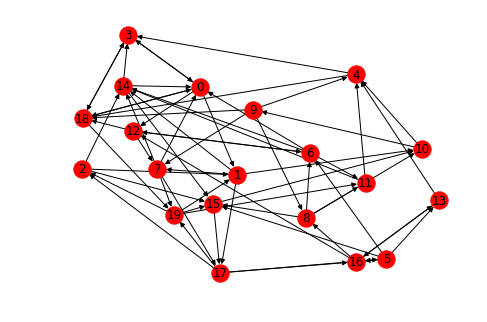

In [1152]:
nx.draw(G, with_labels=True)
plt.show()

In [1153]:
max_out_degree = max(G.out_degree, key=lambda d: d[1])[1]
max_out_degree

4

In [1157]:
def one_hot_encode(idx, length=max_out_degree):
    
    ret = np.zeros(length)
    ret[idx] = 1.0
    return ret

def generate_dataset(G):
    
    X, y = [], []
    
    for node in G.nodes:

        if G.out_degree(node) == 0:
            print('Node %d has 0 out degree' % node)
            continue

        init_weight_vec = np.ones(max_out_degree)

        for idx, out_edge in enumerate(G.out_edges(node)):
            init_weight_vec[idx] = G.get_edge_data(node, out_edge[1])['weight']

        out_neighbors = map(lambda t: (t[1], G.get_edge_data(node, t[1])['weight']),  G.out_edges(node))
    #     print(node, min(out_neighbors, key=lambda d: d[1]), len(out_neighbors), sorted(out_neighbors))

    #     label = one_hot_encode(np.argmin(init_weight_vec, axis=0))
        label = min(out_neighbors, key=lambda d: d[1])[1]
    #     print(label, init_weight_vec[np.argmin(init_weight_vec)])
        assert label == init_weight_vec[np.argmin(init_weight_vec)]
        X.append(init_weight_vec)
        y.append(label)
    
    return np.array(X), np.array(y)

features, labels = generate_dataset(G)
print(features.shape)
print(labels.shape)

(20, 4)
(20,)


In [1158]:
def augment_dataset(X, y=None, augmentation_index=10):
    
    X_aug, y_aug = [], []
    indices = np.arange(len(X[0]))
    
    for idx, x in enumerate(X):
        for _ in range(augmentation_index):
            np.random.shuffle(indices)
            
            X_aug.append(x[indices])
            y_aug.append(one_hot_encode(np.argmin(x[indices])))
            
    return np.array(X_aug), np.array(y_aug)

def augment_dataset_extend_features(X, y=None, augmentation_index=10):
    pass

In [1160]:
X_aug, y_aug = augment_dataset(features, labels, augmentation_index=300)
print(X_aug.shape)
print(y_aug.shape)
print(X_aug[0])
print(y_aug[0])

(6000, 4)
(6000, 4)
[ 0.02959594  0.93157038  0.1933844   0.52411087]
[ 1.  0.  0.  0.]


In [1161]:
indices = np.arange(len(X_aug))
np.random.shuffle(indices)
X, y =  X_aug[indices], y_aug[indices]
print(X.shape)
print(y.shape)

(6000, 4)
(6000, 4)


In [1162]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5400, 4)
(5400, 4)
(600, 4)
(600, 4)


In [1163]:
batch_size = 100

train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(X_test, y_test, batch_size=len(y_test))

In [1164]:
def build_model(context=mx.gpu()):
    
    data = mx.sym.var('data')
    label = mx.sym.var('softmax_label')
    
    fc2  = mx.sym.FullyConnected(data=data, num_hidden=32)
    fc2 = mx.sym.Activation(data=fc2, act_type="relu")
    
    fc3  = mx.sym.FullyConnected(data=fc2, num_hidden=max_out_degree)
    mlp  = mx.sym.SoftmaxOutput(data=fc3, label=label)
    
    return mx.mod.Module(symbol=mlp, context=context)

In [1165]:
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout
model = build_model()
model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
model.init_params()

In [1166]:
def custom_acc(label, pred):
    tmp_label = np.argmax(label, axis=1)
    tmp_pred = np.argmax(pred, axis=1)
    return accuracy_score(tmp_label, tmp_pred)

custom_metric = mx.metric.create(custom_acc)

In [1173]:
model.fit(train_iter,  # train data
              eval_data=val_iter,  # validation data
              optimizer='adam',  # use SGD to train
#               optimizer_params={'learning_rate':0.01, 'momentum': 0.9},
              eval_metric=custom_metric,  # report accuracy during training
              batch_end_callback = mx.callback.Speedometer(batch_size, 10), # output progress for each 100 data batches
              num_epoch=20)  # train for at most 10 dataset passes

INFO:root:Epoch[0] Batch [10]	Speed: 101419.48 samples/sec	custom_acc=0.314545
INFO:root:Epoch[0] Batch [20]	Speed: 107897.62 samples/sec	custom_acc=0.584000
INFO:root:Epoch[0] Batch [30]	Speed: 104611.76 samples/sec	custom_acc=0.748000
INFO:root:Epoch[0] Batch [40]	Speed: 93528.91 samples/sec	custom_acc=0.875000
INFO:root:Epoch[0] Batch [50]	Speed: 105887.35 samples/sec	custom_acc=0.931000
INFO:root:Epoch[0] Train-custom_acc=0.980000
INFO:root:Epoch[0] Time cost=0.067
INFO:root:Epoch[0] Validation-custom_acc=0.973333
INFO:root:Epoch[1] Batch [10]	Speed: 108189.85 samples/sec	custom_acc=0.967273
INFO:root:Epoch[1] Batch [20]	Speed: 109394.75 samples/sec	custom_acc=0.972000
INFO:root:Epoch[1] Batch [30]	Speed: 113882.81 samples/sec	custom_acc=0.966000
INFO:root:Epoch[1] Batch [40]	Speed: 110594.70 samples/sec	custom_acc=0.978000
INFO:root:Epoch[1] Batch [50]	Speed: 109695.16 samples/sec	custom_acc=0.977000
INFO:root:Epoch[1] Train-custom_acc=0.990000
INFO:root:Epoch[1] Time cost=0.062
I

INFO:root:Epoch[15] Batch [50]	Speed: 106722.58 samples/sec	custom_acc=0.982000
INFO:root:Epoch[15] Train-custom_acc=0.986667
INFO:root:Epoch[15] Time cost=0.064
INFO:root:Epoch[15] Validation-custom_acc=0.980000
INFO:root:Epoch[16] Batch [10]	Speed: 96636.27 samples/sec	custom_acc=0.973636
INFO:root:Epoch[16] Batch [20]	Speed: 110254.56 samples/sec	custom_acc=0.982000
INFO:root:Epoch[16] Batch [30]	Speed: 97894.83 samples/sec	custom_acc=0.984000
INFO:root:Epoch[16] Batch [40]	Speed: 97703.28 samples/sec	custom_acc=0.982000
INFO:root:Epoch[16] Batch [50]	Speed: 104666.58 samples/sec	custom_acc=0.982000
INFO:root:Epoch[16] Train-custom_acc=0.986667
INFO:root:Epoch[16] Time cost=0.066
INFO:root:Epoch[16] Validation-custom_acc=0.980000
INFO:root:Epoch[17] Batch [10]	Speed: 104601.33 samples/sec	custom_acc=0.973636
INFO:root:Epoch[17] Batch [20]	Speed: 105575.51 samples/sec	custom_acc=0.984000
INFO:root:Epoch[17] Batch [30]	Speed: 107573.84 samples/sec	custom_acc=0.984000
INFO:root:Epoch[1

In [1174]:
pred_train = np.argmax(model.predict(mx.io.NDArrayIter(X_train, y_train, batch_size=len(y_train))).asnumpy(), axis=1)
print('Acc on training set %f' % accuracy_score(np.argmax(y_train, axis=1), pred_train))

pred_test = np.argmax(model.predict(mx.io.NDArrayIter(X_test, y_test, batch_size=len(y_test))).asnumpy(), axis=1)
print('Acc on test set %f' % accuracy_score(np.argmax(y_test, axis=1), pred_test))

Acc on training set 0.985926
Acc on test set 0.980000


In [1175]:
def infer_next_node(G, cur_node):
#     print("In infer_next_node")
    return min(map(lambda t: (t[1], G.get_edge_data(cur_node, t[1])['weight']),  G.out_edges(cur_node)), key=lambda d:d[1])

def nn_infer_next_node(G, cur_node, model):
#     print("In nn_infer_next_node")
    input_vec = np.ones(4)
    
    for idx, out_edge in enumerate(G.out_edges(cur_node)):
        input_vec[idx] = G.get_edge_data(cur_node, out_edge[1])['weight']
    
    
    out_neighbors = map(lambda t: (t[1], G.get_edge_data(cur_node, t[1])['weight']),  G.out_edges(cur_node))
    
    pred_idx = np.argmax(model.predict(mx.io.NDArrayIter(np.array([input_vec]), np.array([0]))).asnumpy()[0])
    return out_neighbors[pred_idx]

def greedy_path_finder(G, src, dst, use_nn=False, model=None):
    
    path = [src]
    cur_node = src
    total_weights = .0
    
    while True:
        
        if len(path) >= G.number_of_nodes():
            return path, total_weights, False
        
        next_node, weight = nn_infer_next_node(G, cur_node, model) if use_nn else infer_next_node(G, cur_node)
        total_weights += weight
        path.append(next_node)
        
        if next_node == dst:
            return path, total_weights, True
        
        cur_node = next_node

In [1180]:
src, dst = 8, 12

print greedy_path_finder(G, src, dst)
print greedy_path_finder(G, src, dst, use_nn=True, model=model)

([8, 6, 12], 0.4186372770005585, True)
([8, 6, 12], 0.4186372770005585, True)


In [1181]:
nx.dijkstra_path(G, 8, 12)

[8, 6, 12]

In [1182]:
def check_greedy_path_finder_acc(G, model):
    
    correct_cnt = 0
    
    for src in G.nodes:
        for dst in G.nodes:
            
            if src == dst:
                continue
            
            path, _, found = greedy_path_finder(G, src, dst)
            nn_path, _, nn_found = greedy_path_finder(G, src, dst, use_nn=True, model=model)
            
            if found == nn_found and path == nn_path:
                correct_cnt = correct_cnt + 1
            else:
                print('src %d dst %d incorrect' % (src, dst))
    
    num_nodes = G.number_of_nodes()
    return float(correct_cnt) / (num_nodes*(num_nodes-1))

In [1190]:
G_1 = generate_low_degree_g()
print(G_1.number_of_nodes())
print(G_1.number_of_edges())

20
67


In [ ]:
check_greedy_path_finder_acc(G_1, model)